Fit channel alignment parameters on small section of beads, test on another small section

`conda activate imgpro`

In [31]:
import os
import tifffile
import numpy as np
import utils
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from nd2reader import ND2Reader
import itk
import glob
import pandas as pd
import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

import itertools
from collections import defaultdict

In [32]:
PTH = r'D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004_chan_alignment.nd2'
NOISE_PTH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\noise\noise_042925.tif'
OUT_PTH = r'C:\Users\munib\POSTDOC\DATA\fluorescent_beads_ch_align\validation'

STACK_LENGTH = 41
num_frames_beads, H, W, C = utils.get_range_from_nd2(PTH, stack_length=STACK_LENGTH) 
print('Shape of beads data, FZCHW:', num_frames_beads, STACK_LENGTH, C, H, W)

noise_stack = utils.get_noise_stack(NOISE_PTH)
print('Shape of noise stack, ZCHW:', noise_stack.shape)

# Grid patch configuration
PATCH_SIZE = 50  # Size of each patch (50x50)
GRID_OVERLAP = 0  # Overlap between patches (set to 0 for non-overlapping)

Shape of beads data, FZCHW: 50 41 2 512 512
Shape of noise stack, ZCHW: (41, 2, 512, 512)


# FUNCTIONS

In [33]:
def get_stack(input_nd2, index, noise_stack, stack_shape=(41, 2, 512, 512), zplane_to_keep=(2,-1)):
    """Extracts and preprocesses a specific stack from the ND2 file, returns float32 array with trimmed z-slices."""

    if stack_shape[0]==1:
        noise_stack = np.mean(noise_stack,axis=0)
        noise_stack = noise_stack[np.newaxis,:,:,:]
    elif stack_shape[0] != 41:
        noise_stack = np.mean(noise_stack,axis=0)
        noise_stack = noise_stack[np.newaxis,:,:,:]

    stack = np.zeros(stack_shape, np.float32)
    frame_indices = np.arange(stack_shape[0] * index, stack_shape[0] * (index + 1))
    with ND2Reader(input_nd2) as f:
        for i, j in enumerate(frame_indices):
            stack[i] = f.get_frame_2D(0, j), f.get_frame_2D(1, j)
    denoised = np.clip(stack - noise_stack, 0, 4095)

    if stack_shape[0]==1:
        return denoised
    else:
        start, end = zplane_to_keep

        if end == -1:
            return denoised[start:]
        else:
            return denoised[start:end+1]


def generate_grid_patches(H, W, patch_size=50, overlap=0):
    """Generate grid of patch coordinates across the image.
    
    Args:
        H: Image height
        W: Image width
        patch_size: Size of each square patch
        overlap: Overlap between adjacent patches
        
    Returns:
        List of tuples: [(x_start, x_end, y_start, y_end, patch_name), ...]
    """
    step = patch_size - overlap
    patches = []
    
    for i, x_start in enumerate(range(0, H - patch_size + 1, step)):
        for j, y_start in enumerate(range(0, W - patch_size + 1, step)):
            x_end = x_start + patch_size
            y_end = y_start + patch_size
            patch_name = f"patch_{i}_{j}"
            patches.append((x_start, x_end, y_start, y_end, patch_name))
    
    return patches


def get_3d_rigid_parameter_object(num_resolutions=3):
    """Creates an optimized parameter object for 3D rigid registration."""
    parameter_object = itk.ParameterObject.New()
    parameter_map = parameter_object.GetDefaultParameterMap('rigid', num_resolutions)
    
    parameter_map['Transform'] = ['EulerTransform']
    parameter_map['AutomaticScalesEstimation'] = ['true']
    parameter_map['MaximumNumberOfIterations'] = ['1024']
    parameter_map['NumberOfSpatialSamples'] = ['4096']
    parameter_map['Metric'] = ['AdvancedMattesMutualInformation']
    parameter_map['Interpolator'] = ['BSplineInterpolator']
    parameter_map['ResampleInterpolator'] = ['FinalBSplineInterpolator']
    parameter_map['FinalBSplineInterpolationOrder'] = ['3']
    
    parameter_object.AddParameterMap(parameter_map)
    return parameter_object


def align_channels_3d(stack, parameter_object, index=None):
    """Aligns GFP to RFP channel using the entire 3D volume.
    
    Args:
        stack: 4D array of shape (Z, C, H, W) where C=2 (GFP, RFP)
        parameter_object: ITK elastix parameter object for registration
    
    Returns:
        params: Registration transform parameters
    """
    gfp_moving = stack[:, 0, :, :].astype(np.float32)
    rfp_fixed = stack[:, 1, :, :].astype(np.float32)
        
    rfp_fixed_itk = itk.image_view_from_array(rfp_fixed)
    gfp_moving_itk = itk.image_view_from_array(gfp_moving)
    
    _, params = itk.elastix_registration_method(
        rfp_fixed_itk, gfp_moving_itk,
        parameter_object=parameter_object, 
        number_of_threads=8,
        log_to_console=False
    )

    return params


def extract_frame_from_path(path):
    filename_with_ext = os.path.basename(path)
    filename_without_ext = os.path.splitext(filename_with_ext)[0]
    return int(filename_without_ext)


def get_transform_params(file, parameter_object):
    """Extracts transform parameters from a text file."""
    parameter_object.ReadParameterFile(file)
    param_map = parameter_object.GetParameterMap(0)
    return {
        'CenterOfRotationPoint': np.array(param_map['CenterOfRotationPoint'], float),
        'Size': np.array(param_map['Size'], int),
        'TransformParameters': np.array(param_map['TransformParameters'], float)
    }


def compute_median_params(param_files, parameter_object):
    """Compute median parameters from a list of parameter files."""
    all_params = []
    for file in param_files:
        params = get_transform_params(file, parameter_object)
        all_params.append(params)
    
    median_center = np.median(np.array([p['CenterOfRotationPoint'] for p in all_params]), axis=0)
    median_size = np.median(np.array([p['Size'] for p in all_params]), axis=0).astype(int)
    median_transform = np.median(np.array([p['TransformParameters'] for p in all_params]), axis=0)
    
    return {
        'CenterOfRotationPoint': median_center,
        'Size': median_size,
        'TransformParameters': median_transform
    }


def create_parameter_object_from_median(median_params, template_path):
    """Create a parameter object from median parameters."""
    parameter_object = itk.ParameterObject.New()
    parameter_object.ReadParameterFile(template_path)
    changed_param_map = parameter_object.GetParameterMap(0)
    changed_param_map['CenterOfRotationPoint'] = [f'{v:.15f}' for v in median_params['CenterOfRotationPoint']]
    changed_param_map['Size'] = [str(v) for v in median_params['Size']]
    changed_param_map['TransformParameters'] = [f'{v:.15f}' for v in median_params['TransformParameters']]
    parameter_object.SetParameterMap(0, changed_param_map)
    return parameter_object


def apply_registration(data, parameter_object):
    """Apply registration to GFP channel and combine with RFP.
    
    Args:
        data: Array of shape (Z, C, H, W) where C=2 (GFP, RFP)
        parameter_object: ITK parameter object with transform
        
    Returns:
        registered: Array of shape (C, Z, H, W) with registered GFP and original RFP
    """
    gfp_moving = data[:, 0, :, :].astype(np.float32)
    gfp_registered = np.array(itk.transformix_filter(itk.image_from_array(gfp_moving), parameter_object))
    
    # Stack as (C, Z, H, W) for visualization
    rfp_fixed = data[:, 1, :, :]
    registered = np.stack([gfp_registered, rfp_fixed], axis=0)
    return registered


def compute_alignment_quality(gfp, rfp):
    """Compute normalized cross-correlation between GFP and RFP channels."""
    gfp_flat = gfp.flatten()
    rfp_flat = rfp.flatten()
    
    gfp_norm = gfp_flat - np.mean(gfp_flat)
    rfp_norm = rfp_flat - np.mean(rfp_flat)
    
    ncc = np.sum(gfp_norm * rfp_norm) / (np.linalg.norm(gfp_norm) * np.linalg.norm(rfp_norm) + 1e-8)
    return ncc

# MAIN

In [ ]:
# Estimate channel alignment for each grid patch

channel_align_parameter_object = get_3d_rigid_parameter_object(num_resolutions=3)

# Generate grid patches
patches = generate_grid_patches(H, W, patch_size=PATCH_SIZE, overlap=GRID_OVERLAP)
print(f"Generated {len(patches)} patches of size {PATCH_SIZE}x{PATCH_SIZE}")

# Create output directories for each patch
for patch in patches:
    patch_name = patch[4]
    os.makedirs(os.path.join(OUT_PTH, patch_name, 'txt'), exist_ok=True)

# Load all stacks first
print("Loading all stacks...")
all_stacks = np.zeros((num_frames_beads, STACK_LENGTH-2, C, H, W), np.float32)
for i in tqdm.tqdm(range(num_frames_beads), desc="Loading stacks"):
    all_stacks[i] = get_stack(PTH, i, noise_stack)
    all_stacks[i] = np.clip(all_stacks[i], 0, 4095).astype(np.float32)

# Estimate alignment parameters for each patch across all frames
print("\nEstimating alignment parameters for each patch...")
patch_params = defaultdict(list)  # Store parameter files per patch

for patch in tqdm.tqdm(patches, desc="Processing patches"):
    x_start, x_end, y_start, y_end, patch_name = patch
    patch_dir = os.path.join(OUT_PTH, patch_name, 'txt')
    
    for frame_idx in range(num_frames_beads):
        # Extract patch from stack
        patch_data = all_stacks[frame_idx, :, :, x_start:x_end, y_start:y_end]
        
        # Estimate alignment parameters
        try:
            params = align_channels_3d(patch_data, channel_align_parameter_object)
            
            # Save parameters
            txt_fn = os.path.join(patch_dir, f"{frame_idx:04d}.txt")
            params.WriteParameterFile(params, txt_fn)
            patch_params[patch_name].append(txt_fn)
        except Exception as e:
            print(f"Error processing {patch_name} frame {frame_idx}: {e}")

print(f"\nSaved alignment parameters for {len(patches)} patches")

Generated 100 patches of size 50x50
Loading all stacks...


Loading stacks: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



Estimating alignment parameters for each patch...


Processing patches:   2%|▏         | 2/100 [01:58<1:36:26, 59.05s/it]

Error processing patch_0_2 frame 18: D:\a\im\build\cp311-abi3-win_amd64\_deps\elx-src\Core\Main\itkElastixRegistrationMethod.hxx:389:
ITK ERROR: ElastixRegistrationMethod(00000241BF9C7E60): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).


Processing patches:  43%|████▎     | 43/100 [44:28<59:51, 63.00s/it]  

In [ ]:
# Compute median parameters for each patch

TEMPLATE_PATH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\template_3d.txt'
parameter_object_template = itk.ParameterObject.New()

median_params_per_patch = {}
patch_parameter_objects = {}

for patch in tqdm.tqdm(patches, desc="Computing median params"):
    patch_name = patch[4]
    param_files = sorted(patch_params[patch_name], key=extract_frame_from_path)
    
    if len(param_files) > 0:
        median_params = compute_median_params(param_files, parameter_object_template)
        median_params_per_patch[patch_name] = median_params
        
        # Create parameter object for this patch
        patch_param_obj = create_parameter_object_from_median(median_params, TEMPLATE_PATH)
        patch_parameter_objects[patch_name] = patch_param_obj
        
        # Save median alignment file
        align_path = os.path.join(OUT_PTH, patch_name, 'chan_align.txt')
        patch_param_obj.WriteParameterFile(patch_param_obj, align_path)

print(f"Computed median parameters for {len(median_params_per_patch)} patches")

# Save summary of all transform parameters
summary_data = []
for patch_name, params in median_params_per_patch.items():
    row = {'patch': patch_name}
    for i, v in enumerate(params['TransformParameters']):
        row[f'param_{i}'] = v
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(OUT_PTH, 'all_patches_params_summary.csv'), index=False)
print("Saved parameter summary to all_patches_params_summary.csv")

In [ ]:
# Cell: Cross-validate - Test each patch's alignment on all other patches

test_frame = 3  # Frame to use for testing

# Compute alignment quality matrix
n_patches = len(patches)
quality_matrix = np.zeros((n_patches, n_patches))  # [train_patch, test_patch]

print("Cross-validating alignment parameters...")
for i, train_patch in enumerate(tqdm.tqdm(patches, desc="Training patches")):
    train_name = train_patch[4]
    
    if train_name not in patch_parameter_objects:
        continue
        
    train_param_obj = patch_parameter_objects[train_name]
    
    for j, test_patch in enumerate(patches):
        x_start, x_end, y_start, y_end, test_name = test_patch
        
        # Extract test patch data
        test_data = all_stacks[test_frame, :, :, x_start:x_end, y_start:y_end]
        
        try:
            # Apply training patch's alignment to test patch
            registered = apply_registration(test_data, train_param_obj)
            
            # Compute alignment quality (NCC between registered GFP and RFP)
            quality = compute_alignment_quality(registered[0], registered[1])
            quality_matrix[i, j] = quality
        except Exception as e:
            quality_matrix[i, j] = np.nan

# Save quality matrix
np.save(os.path.join(OUT_PTH, 'cross_validation_quality_matrix.npy'), quality_matrix)
print("Saved cross-validation quality matrix")

In [ ]:
# Cell: Visualize cross-validation results as heatmap

%matplotlib widget
plt.close('all')

fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
im = ax.imshow(quality_matrix, cmap='viridis', aspect='auto')
ax.set_xlabel('Test Patch Index')
ax.set_ylabel('Training Patch Index')
ax.set_title('Cross-Validation: Alignment Quality (NCC)\n(Row: training patch, Column: test patch)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Cross-Correlation')

# Add diagonal line for reference
ax.plot([0, n_patches-1], [0, n_patches-1], 'r--', linewidth=2, label='Same patch (train=test)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics
diag_quality = np.diag(quality_matrix)
off_diag_mask = ~np.eye(n_patches, dtype=bool)
off_diag_quality = quality_matrix[off_diag_mask]

print(f"\nAlignment Quality Statistics:")
print(f"  Diagonal (same patch): mean={np.nanmean(diag_quality):.4f}, std={np.nanstd(diag_quality):.4f}")
print(f"  Off-diagonal (cross): mean={np.nanmean(off_diag_quality):.4f}, std={np.nanstd(off_diag_quality):.4f}")

# Find best and worst performing training patches
mean_quality_per_train = np.nanmean(quality_matrix, axis=1)
best_train_idx = np.nanargmax(mean_quality_per_train)
worst_train_idx = np.nanargmin(mean_quality_per_train)
print(f"\nBest training patch: {patches[best_train_idx][4]} (mean NCC={mean_quality_per_train[best_train_idx]:.4f})")
print(f"Worst training patch: {patches[worst_train_idx][4]} (mean NCC={mean_quality_per_train[worst_train_idx]:.4f})")

In [ ]:
# Cell: Visualize sample patches - before and after registration

%matplotlib widget
plt.close('all')

# Select patches to visualize
# Use best, worst, and a few random patches for comparison
viz_indices = [best_train_idx, worst_train_idx]
viz_indices.extend(np.random.choice(range(n_patches), size=min(4, n_patches-2), replace=False).tolist())
viz_indices = list(set(viz_indices))[:6]  # Limit to 6 patches

# Select a test patch different from training patches
test_patch_idx = (viz_indices[0] + n_patches // 2) % n_patches
test_patch = patches[test_patch_idx]
test_x_start, test_x_end, test_y_start, test_y_end, test_patch_name = test_patch

# Get test data
test_data = all_stacks[test_frame, :, :, test_x_start:test_x_end, test_y_start:test_y_end]

# Visualization settings
mn, mx = 0, 100
z_slice = test_data.shape[0] // 2  # Middle z-slice
cmap_gfp = 'magenta'
cmap_rfp = 'cyan'

n_viz = len(viz_indices) + 1  # +1 for original
fig, axes = plt.subplots(2, n_viz, figsize=(4*n_viz, 8))

# Plot original (unregistered) test patch
axes[0, 0].imshow(test_data[z_slice, 0], cmap=cmap_gfp, vmin=mn, vmax=mx)
axes[0, 0].set_title(f'Original GFP\n{test_patch_name}')
axes[0, 0].axis('off')

axes[1, 0].imshow(test_data[z_slice, 1], cmap=cmap_rfp, vmin=mn, vmax=mx)
axes[1, 0].set_title(f'Original RFP\n{test_patch_name}')
axes[1, 0].axis('off')

# Plot registered versions using different training patches
for col, train_idx in enumerate(viz_indices, start=1):
    train_patch = patches[train_idx]
    train_name = train_patch[4]
    
    if train_name in patch_parameter_objects:
        registered = apply_registration(test_data, patch_parameter_objects[train_name])
        quality = quality_matrix[train_idx, test_patch_idx]
        
        # GFP (registered)
        axes[0, col].imshow(registered[0, z_slice], cmap=cmap_gfp, vmin=mn, vmax=mx)
        axes[0, col].set_title(f'GFP (train: {train_name})\nNCC={quality:.4f}')
        axes[0, col].axis('off')
        
        # RFP (unchanged)
        axes[1, col].imshow(registered[1, z_slice], cmap=cmap_rfp, vmin=mn, vmax=mx)
        axes[1, col].set_title(f'RFP')
        axes[1, col].axis('off')
    else:
        axes[0, col].text(0.5, 0.5, 'No params', ha='center', va='center', transform=axes[0, col].transAxes)
        axes[1, col].text(0.5, 0.5, 'No params', ha='center', va='center', transform=axes[1, col].transAxes)

plt.suptitle(f'Test Patch: {test_patch_name} (z-slice {z_slice})\nApplying alignment from different training patches', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Cell: Visualize with Microanim - Full z-stack comparison

%matplotlib widget
plt.close('all')

# Settings
mn, mx = 0, 100
fs = 3
dpi = 100
cmap = ['magenta', 'cyan']

# Select best training patch for visualization
best_train_name = patches[best_train_idx][4]
best_param_obj = patch_parameter_objects[best_train_name]

# Get the training patch data
train_patch = patches[best_train_idx]
train_x_start, train_x_end, train_y_start, train_y_end, _ = train_patch
train_data = all_stacks[test_frame, :, :, train_x_start:train_x_end, train_y_start:train_y_end]

# Get a different test patch
test_patch = patches[test_patch_idx]
test_x_start, test_x_end, test_y_start, test_y_end, test_name = test_patch
test_data = all_stacks[test_frame, :, :, test_x_start:test_x_end, test_y_start:test_y_end]

# Apply registration
train_registered = apply_registration(train_data, best_param_obj)
test_registered = apply_registration(test_data, best_param_obj)

# Original data needs to be transposed to (C, Z, H, W) for Microanim
train_original = train_data.transpose(1, 0, 2, 3)  # (Z, C, H, W) -> (C, Z, H, W)
test_original = test_data.transpose(1, 0, 2, 3)

# Create animations
anim1 = Microanim(
    data=train_original, cmaps=cmap, flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[mn, mx], label_text=f'Train Original ({best_train_name})')

anim2 = Microanim(
    data=train_registered, cmaps=cmap, flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[mn, mx], label_text=f'Train Registered ({best_train_name})')

anim3 = Microanim(
    data=test_original, cmaps=cmap, flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[mn, mx], label_text=f'Test Original ({test_name})')

anim4 = Microanim(
    data=test_registered, cmaps=cmap, flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[mn, mx], label_text=f'Test Registered ({test_name})')

# Create panel
animpanel = Microanimpanel(rows=2, cols=2)
animpanel.add_element(pos=[0, 0], microanim=anim1)
animpanel.add_element(pos=[0, 1], microanim=anim2)
animpanel.add_element(pos=[1, 0], microanim=anim3)
animpanel.add_element(pos=[1, 1], microanim=anim4)
animpanel.ui

In [ ]:
# Cell: Visualize spatial distribution of alignment quality

%matplotlib widget
plt.close('all')

# Create a spatial map of alignment quality
# For each patch, show the mean quality when using that patch for training

# Calculate grid dimensions
n_rows = max(int(p[4].split('_')[1]) for p in patches) + 1
n_cols = max(int(p[4].split('_')[2]) for p in patches) + 1

# Create spatial quality map
spatial_quality = np.zeros((n_rows, n_cols))
for i, patch in enumerate(patches):
    row = int(patch[4].split('_')[1])
    col = int(patch[4].split('_')[2])
    spatial_quality[row, col] = mean_quality_per_train[i]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Mean quality when using each patch for training
im1 = axes[0].imshow(spatial_quality, cmap='viridis', aspect='equal')
axes[0].set_xlabel('Patch Column')
axes[0].set_ylabel('Patch Row')
axes[0].set_title('Mean Alignment Quality by Training Patch Location')
plt.colorbar(im1, ax=axes[0], label='Mean NCC')

# Plot 2: Overlay on original image
# Show patch grid on a sample frame
sample_mip = np.max(all_stacks[test_frame, :, 0, :, :], axis=0)  # GFP MIP
axes[1].imshow(sample_mip, cmap='gray', vmin=0, vmax=100)

# Draw patch grid with color-coded quality
for i, patch in enumerate(patches):
    x_start, x_end, y_start, y_end, patch_name = patch
    quality = mean_quality_per_train[i]
    
    # Normalize quality for color
    norm_quality = (quality - np.nanmin(mean_quality_per_train)) / (np.nanmax(mean_quality_per_train) - np.nanmin(mean_quality_per_train) + 1e-8)
    color = plt.cm.viridis(norm_quality)
    
    rect = plt.Rectangle((y_start, x_start), y_end - y_start, x_end - x_start,
                          linewidth=2, edgecolor=color, facecolor='none', alpha=0.8)
    axes[1].add_patch(rect)

axes[1].set_title('Patch Grid Overlay on GFP MIP\n(Color = Mean NCC quality)')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

# OLD

In [23]:
# get registration parameters from a subset of the (x,y) plane
frame = 3
train_x_range_plot = (0,256)
train_y_range_plot = (0,256)
test_x_range = (256,512)
test_y_range = (256,512)

train_data = stack[frame, :, :, train_x_range_plot[0]:train_x_range_plot[1], train_y_range_plot[0]:train_y_range_plot[1]]
test_data = stack[frame, :, :, test_x_range[0]:test_x_range[1], test_y_range[0]:test_y_range[1]]

In [24]:
print(train_data.shape)
print(test_data.shape)

(39, 2, 256, 256)
(39, 2, 256, 256)


In [27]:
# apply registration params object to test range
train_gfp = itk.transformix_filter(train_data[:,0], parameter_object)#[:,train_x_range_plot[0]:train_x_range_plot[1], train_y_range_plot[0]:train_y_range_plot[1]]
test_gfp = itk.transformix_filter(test_data[:,0], parameter_object)#[:,test_x_range[0]:test_x_range[1], test_y_range[0]:test_y_range[1]]

In [28]:
print(train_gfp.shape)
print(test_gfp.shape)

(39, 256, 256)
(39, 256, 256)


In [29]:
train_data_registered = np.concatenate((train_gfp[np.newaxis], train_data[np.newaxis,:,1]), axis=0)
test_data_registered = np.concatenate((test_gfp[np.newaxis], test_data[np.newaxis,:,1]), axis=0)

# train_data_registered = np.concatenate((train_gfp[np.newaxis, :, :, :], stack[frame, :, 1, train_x_range_plot[0]:train_x_range_plot[1], train_y_range_plot[0]:train_y_range_plot[1]][np.newaxis]), axis=0)
# test_data_registered = np.concatenate((test_gfp[np.newaxis, :, :, :], stack[frame, :, 1, test_x_range[0]:test_x_range[1], test_y_range[0]:test_y_range[1]][np.newaxis]), axis=0)
print(train_data_registered.shape)

(2, 39, 256, 256)


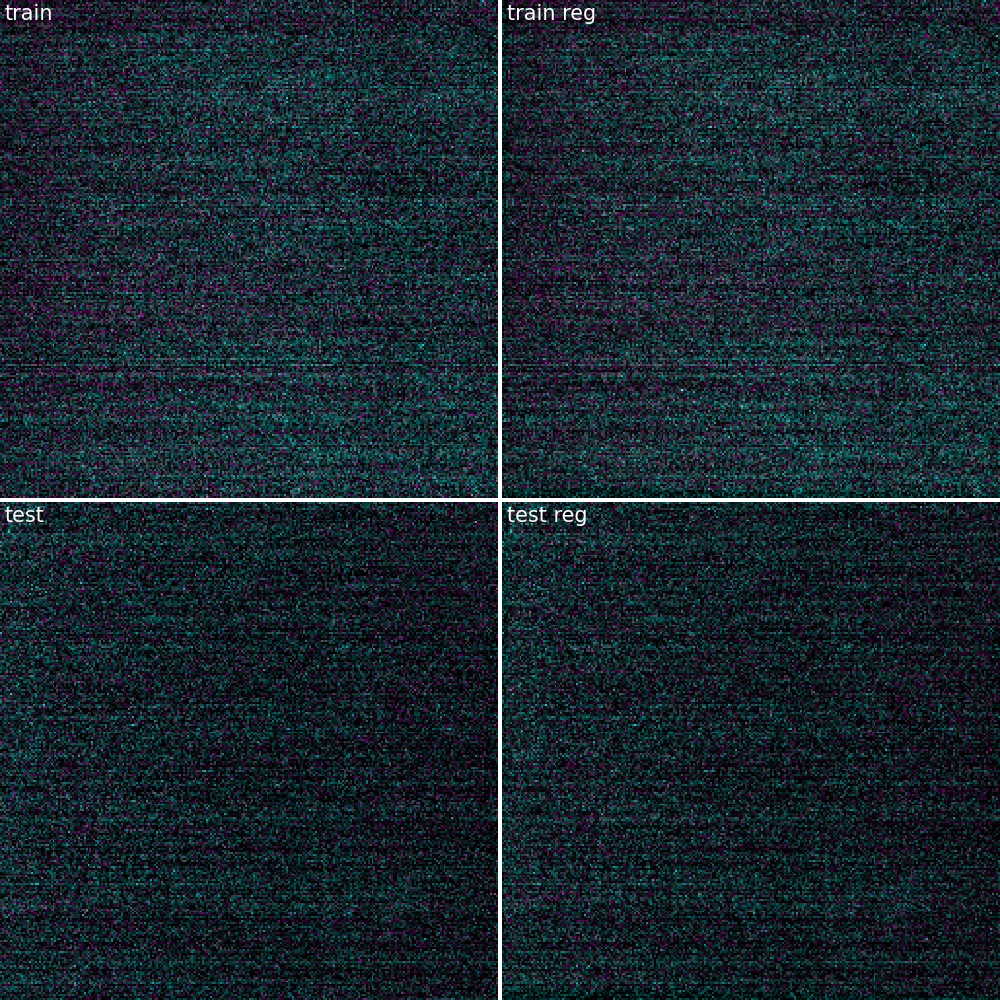

In [30]:
# plot with microanim

%matplotlib widget

plt.close('all')

mn = 0
mx = 100
# mx = 100
fs = 3
dpi = 100

cmap = ['magenta', 'cyan']

anim1 = Microanim(
    data=train_data.transpose(1,0,2,3)[:,:,train_x_range[0]:train_x_range[1], train_y_range[0]:train_y_range[1]], cmaps=[cmap[0], cmap[1]], flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[mn,mx], label_text='train')
anim2 = Microanim(
    data=train_data_registered[:,:,train_x_range[0]:train_x_range[1], train_y_range[0]:train_y_range[1]], cmaps=[cmap[0], cmap[1]], flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[mn,mx], label_text='train reg')
anim3 = Microanim(
    data=test_data.transpose(1,0,2,3), cmaps=[cmap[0], cmap[1]], flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='test')
anim4 = Microanim(
    data=test_data_registered, cmaps=[cmap[0], cmap[1]], flip_map=False, fig_scaling=fs, dpi=dpi,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='test reg')

plt.close('all')

animpanel = Microanimpanel(rows=2, cols=2,)
animpanel.add_element(pos=[0,0], microanim=anim1)
animpanel.add_element(pos=[0,1], microanim=anim2)
animpanel.add_element(pos=[1,0], microanim=anim3)
animpanel.add_element(pos=[1,1], microanim=anim4)
animpanel.ui

